# Code Explanation

This script computes **robust standard errors (HC0)** for regression coefficients obtained from a linear model, addressing heteroscedasticity in the residuals. It utilizes the "sandwich" estimator method to provide robust inference. Here's a breakdown of the main components:

## Imports
- **`numpy`**: For numerical operations and matrix manipulations.
- **`scipy.stats`**: For statistical tests and probability distributions.
- **`tabulate`**: For formatted coefficient tables.
- **`pandas`**: For handling input data in DataFrame format.

## `robust_se_hc0` Function

### 1. **Inputs**
- **`data`**: Dataset where the first column is the dependent variable (\(Y\)) and the remaining columns are the independent variables.
- **`model_results`**: Output from a linear regression function like `linear_model` or `mle_model`, containing coefficients.
- **`feature_names`** *(optional)*: Names of the dependent and independent variables.

### 2. **Data Preparation**
- Converts the input data to a numpy array for processing if it is a DataFrame.
- Constructs the design matrix (`X`) with an intercept term.
- Extracts the dependent variable (\(Y\)) and the independent variables (\(X\)).

### 3. **Coefficient and Residual Computation**
- Retrieves the estimated coefficients from the `model_results`.
- Computes the predicted values (\(Y_{\text{hat}}\)) and residuals (\(Y - Y_{\text{hat}}\)).

### 4. **Robust Covariance Matrix**
- Uses the **sandwich estimator** to calculate the robust covariance matrix for heteroscedasticity-robust standard errors:
  - **Bread**: The inverse of \(X^T X\).
  - **Meat**: \(X^T D X\), where \(D\) is a diagonal matrix of squared residuals.
  - Combines the bread and meat matrices to calculate the sandwich covariance matrix.

### 5. **Robust Standard Errors and Statistics**
- Extracts robust standard errors from the diagonal of the sandwich covariance matrix.
- Calculates robust \(t\)-statistics and \(p\)-values for hypothesis testing.
- Computes additional model diagnostics:
  - **R-squared and Adjusted R-squared**: Measures of model fit.
  - **F-statistic and F-test P-value**: Tests the overall significance of the model.

### 6. **Coefficient Table**
- Formats the results into a table including:
  - **Variable Name**: Names of predictors and intercept.
  - **Coefficient**: Estimated regression coefficients.
  - **Robust SE**: Heteroscedasticity-robust standard errors.
  - **t-value**: Test statistics.
  - **p-value**: Significance levels.

### 7. **Output**
- Returns a dictionary containing:
  - **Summary**: A text-based summary of the results with formatted tables.
  - **Coefficients**: A DataFrame of the coefficients and their robust statistics.
  - **R-squared and Adjusted R-squared**: Model fit metrics.
  - **F-statistic and F-test P-value**: Measures of overall model significance.
  - **Residuals**: Flattened residuals for further analysis.
  - **Robust SE**: Robust standard errors.

### Use Case
This function is particularly useful in regression analysis when the assumption of constant variance in residuals (homoscedasticity) is violated. By providing robust standard errors, it ensures valid statistical inference in the presence of heteroscedasticity.


In [1]:
import numpy as np
from scipy import stats, optimize
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def mle_model(data, feature_names=None):
    """
    Maximum Likelihood Estimation (MLE) for Linear Model
    """
    # Data preparation
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    if data.shape[1] < 2:
        raise ValueError("The data must contain at least two columns")
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    def log_likelihood(params):
        """Negative log-likelihood function"""
        beta = params[:-1].reshape(-1, 1)
        sigma = np.exp(params[-1])  # Ensure sigma is positive
        residuals = y - X @ beta
        ll = -0.5 * len(X) * np.log(2 * np.pi * sigma**2) - \
             (1 / (2 * sigma**2)) * np.sum(residuals**2)
        return -ll  # Return negative because we're minimizing
    
    # Initialize parameters (beta and log(sigma))
    init_params = np.zeros(X.shape[1] + 1)
    init_params[-1] = np.log(np.std(y))
    
    # Optimize using MLE
    mle_result = optimize.minimize(
        log_likelihood,
        init_params,
        method='BFGS',
        options={'disp': False}
    )
    
    # Extract results
    beta_mle = mle_result.x[:-1].reshape(-1, 1)
    sigma_mle = np.exp(mle_result.x[-1])
    log_lik = -mle_result.fun
    
    # Calculate standard errors using OLS approach
    y_hat = X @ beta_mle
    residuals = y - y_hat
    n = len(X)
    p = X.shape[1]
    
    # Calculate MSE
    mse = np.sum(residuals**2) / (n - p)
    
    # Calculate standard errors
    try:
        XtX_inv = np.linalg.inv(X.T @ X)
        se_beta_mle = np.sqrt(np.diag(XtX_inv * mse))
        
        # Calculate test statistics
        t_values = beta_mle.flatten() / se_beta_mle
        p_values = 2 * stats.t.sf(np.abs(t_values), df=n-p)
    except np.linalg.LinAlgError:
        print("Warning: Could not compute standard errors (singular matrix)")
        se_beta_mle = np.full(len(beta_mle), np.nan)
        t_values = np.full(len(beta_mle), np.nan)
        p_values = np.full(len(beta_mle), np.nan)
    
    # Calculate R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # Calculate AIC and BIC
    k = len(init_params)  # number of parameters (including sigma)
    aic = 2 * k - 2 * log_lik
    bic = np.log(n) * k - 2 * log_lik
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuals vs Fitted
    axes[0,0].scatter(y_hat.flatten(), residuals.flatten())
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Fitted values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('Residuals vs Fitted')
    
    # Q-Q plot
    stats.probplot(residuals.flatten(), dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Normal Q-Q Plot')
    
    # Scale-Location plot
    axes[1,0].scatter(y_hat.flatten(), np.sqrt(np.abs(residuals.flatten())))
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('√|Residuals|')
    axes[1,0].set_title('Scale-Location Plot')
    
    # Density plot of residuals
    sns.kdeplot(data=residuals.flatten(), ax=axes[1,1])
    axes[1,1].set_title('Residuals Density Plot')
    
    plt.tight_layout()
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta_mle)):
        coef_data.append([
            var_names[i],
            f"{beta_mle[i][0]:.4f}",
            f"{se_beta_mle[i]:.4f}",
            f"{t_values[i]:.4f}",
            f"{p_values[i]:.4f}"
        ])
    
    return {
        'summary': f"""
Maximum Likelihood Estimation Results
===================================
Dependent Variable: {feature_names[0]}
Number of Observations: {len(X)}
Number of Predictors: {X.shape[1]-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
Log-likelihood: {log_lik:.4f}
AIC: {aic:.4f}
BIC: {bic:.4f}
Sigma (MLE): {sigma_mle:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'log_likelihood': log_lik,
        'aic': aic,
        'bic': bic,
        'sigma': sigma_mle,
        'residuals': residuals.flatten(),
        'fitted_values': y_hat.flatten(),
        'diagnostic_plots': fig
    }



In [2]:
import numpy as np
from scipy import stats
from tabulate import tabulate
import pandas as pd

def robust_se_hc0(data, model_results, feature_names=None):
    """
    Calculate Robust Standard Errors (HC0)
    
    Parameters:
    -----------
    data : numpy.ndarray or pandas.DataFrame
        Data where the first column is the dependent variable (Y) and 
        the remaining columns are the independent variables
    model_results : dict
        Results from the mle_model or linear_model function
    feature_names : list, optional
        Names of the features (including dependent variable)
        
    Returns:
    --------
    dict
        Dictionary containing the coefficients with robust standard errors
        and other statistics
    """
    # Data preparation
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    # Extract estimated coefficients
    beta = model_results['coefficients']['Coefficient'].values
    beta = np.array([float(b) for b in beta]).reshape(-1, 1)
    
    # Calculate predicted values and residuals
    y_hat = X @ beta
    residuals = y - y_hat
    
    # Calculate robust covariance matrix (HC0)
    n = len(data)
    p = X.shape[1]
    X_t = X.T
    residuals_diag = np.diag(residuals.flatten()**2)
    meat = X_t @ residuals_diag @ X
    bread = np.linalg.inv(X_t @ X)
    sandwich = bread @ meat @ bread
    
    # Robust standard errors
    robust_se = np.sqrt(np.diag(sandwich))
    
    # Calculate robust test statistics
    t_values_robust = beta.flatten() / robust_se
    p_values_robust = 2 * stats.t.sf(np.abs(t_values_robust), df=n-p)
    
    # Calculate R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # Calculate F-statistic
    MS_reg = (SS_tot - SS_res) / (p - 1)
    MS_res = SS_res / (n - p)
    f_statistic = MS_reg / MS_res
    f_pvalue = stats.f.sf(f_statistic, p-1, n-p)
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta)):
        coef_data.append([
            var_names[i],
            f"{beta[i][0]:.4f}",
            f"{robust_se[i]:.4f}",
            f"{t_values_robust[i]:.4f}",
            f"{p_values_robust[i]:.4f}"
        ])
    
    return {
        'summary': f"""
Robust Standard Errors (HC0) Results
==================================
Dependent Variable: {feature_names[0]}
Number of Observations: {n}
Number of Predictors: {p-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
F-statistic: {f_statistic:.4f}
F-test P-value: {f_pvalue:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Robust SE', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Robust SE', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_statistic': f_statistic,
        'f_pvalue': f_pvalue,
        'robust_se': robust_se,
        'residuals': residuals.flatten()
    }




Robust Standard Errors (HC0) Results
Dependent Variable: Y
Number of Observations: 200
Number of Predictors: 3

Model Statistics:
----------------
R-squared: 0.4279
Adjusted R-squared: 0.4191
F-statistic: 48.8580
F-test P-value: 0.0000

Coefficients:
------------
| Variable   |   Coefficient |   Robust SE |   t-value |   p-value |
|:-----------|--------------:|------------:|----------:|----------:|
| Intercept  |        2.9072 |      0.2053 |   14.1589 |    0.0000 |
| X1         |        0.3811 |      0.3312 |    1.1506 |    0.2513 |
| X2         |       -0.8004 |      0.2265 |   -3.5333 |    0.0005 |
| X3         |        2.3608 |      0.1972 |   11.9701 |    0.0000 |



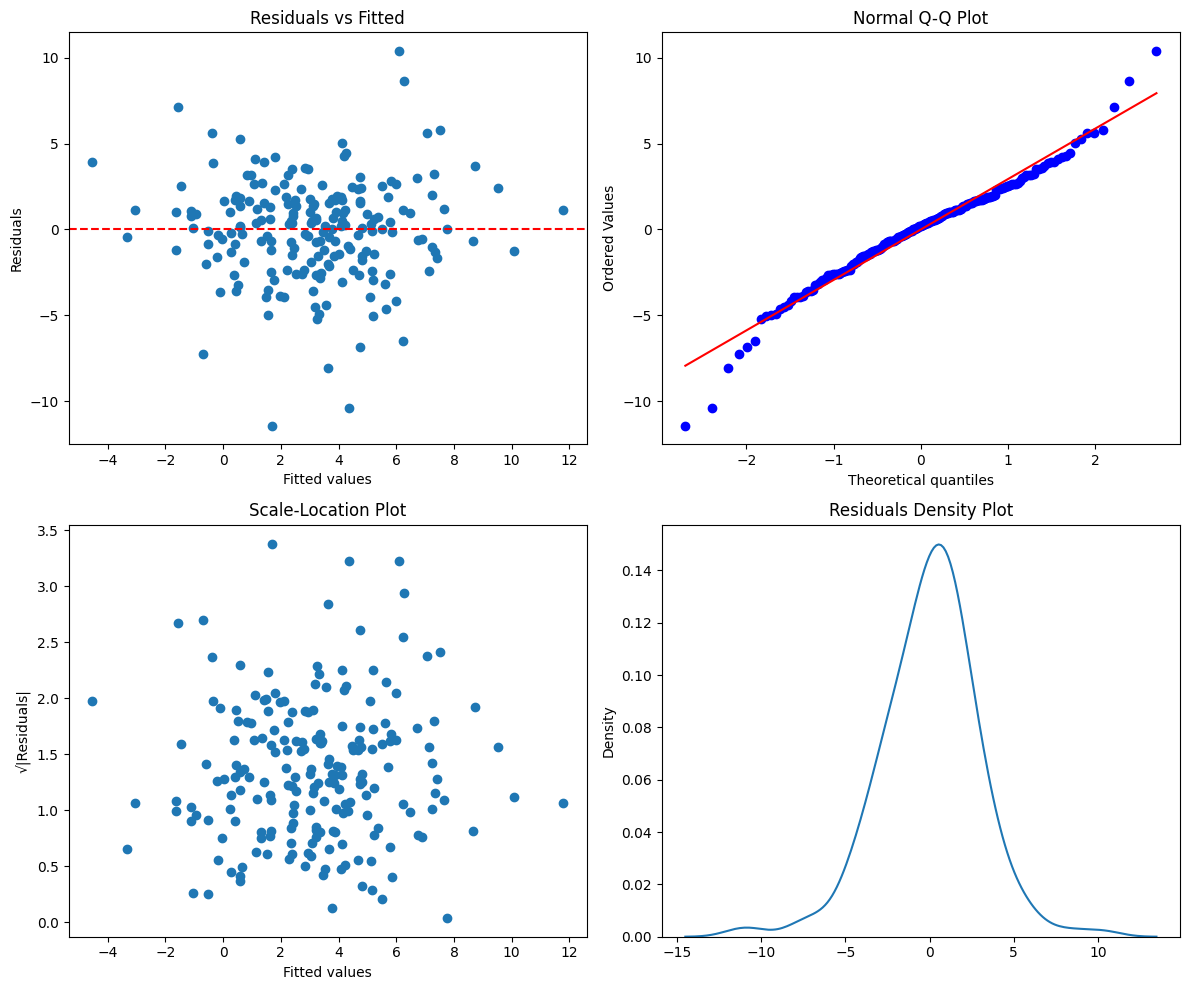

In [3]:
# Example usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    n = 200
    
    # True parameters
    beta_true = np.array([3, 0.5, -1, 2])
    sigma_true = 2
    
    # Generate predictors
    X = np.random.normal(0, 1, (n, 3))
    
    # Generate response with heteroskedastic errors
    y = beta_true[0] + X @ beta_true[1:] + \
        np.random.normal(0, sigma_true * (1 + 0.5 * X[:, 0]**2), n)
    
    # Create dataset
    data = np.column_stack([y, X])
    feature_names = ['Y', 'X1', 'X2', 'X3']
    

    model_results = mle_model(data, feature_names)
    
    # Calculate robust standard errors
    robust_results = robust_se_hc0(data, model_results, feature_names)
    
    # Print results
    print(robust_results['summary'])